In [6]:
import os
import ffmpeg
import glob
import mediapipe as mp
import itertools
import cv2
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
import onnx
import sys
import onnxruntime as ort
from IPython.display import clear_output
mp_face_mesh = mp.solutions.face_mesh

ModuleNotFoundError: No module named 'ffmpeg'

In [3]:
conda install onnxruntime


Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\msi\anaconda3

  added / updated specs:
    - onnxruntime


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    coloredlogs-15.0.1         |  py311haa95532_1          93 KB
    humanfriendly-10.0         |  py311haa95532_1         164 KB
    onnxruntime-1.15.1         |  py311h9ed60d2_0         4.2 MB
    protobuf-3.20.3            |  py311hd77b12b_0         282 KB
    pyreadline3-3.4.1          |  py311haa95532_0         198 KB
    python-flatbuffers-2.0     |     pyhd3eb1b0_0          34 KB
    ------------------------------------------------------------
                                           Total:         4.9 MB

The following NEW packages will be INSTALLED:

  coloredlogs        pkgs/main/win-64::coloredlogs-15.0.1-py311haa95532_1 
  humanfriendly      pkgs/main/win-64::humanfriendly-10.0-p

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): repo.anaconda.com:443
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): repo.anaconda.com:443
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): repo.anaconda.com:443
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): repo.anaconda.com:443
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): repo.anaconda.com:443
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): repo.anaconda.com:443
DEBUG:urllib3.connectionpool:https://repo.anaconda.com:443 "GET /pkgs/r/win-64/current_repodata.json HTTP/1.1" 304 0
DEBUG:urllib3.connectionpool:https://repo.anaconda.com:443 "GET /pkgs/msys2/noarch/current_repodata.json HTTP/1.1" 304 0
DEBUG:urllib3.connectionpool:https://repo.anaconda.com:443 "GET /pkgs/main/win-64/current_repodata.json HTTP/1.1" 304 0
DEBUG:urllib3.connectionpool:https://repo.anaconda.com:443 "GET /pkgs/r/noarch/current_repodata.json HTTP/1.1" 304 0
DEBUG:url

In [8]:
import onnxruntime as ort

In [9]:
ort.get_available_providers()


['CPUExecutionProvider']

In [5]:
mp_face_mesh_total = mp.solutions.face_mesh
face_mesh_images_total = mp_face_mesh_total.FaceMesh(static_image_mode=False, max_num_faces=2)

FACEMESH_FACE_INDEXES_total = list(set(itertools.chain(*mp_face_mesh_total.FACEMESH_TESSELATION)))

NameError: name 'mp' is not defined

In [9]:
def make_rect_shape_square(rect):
    # Rect: (x, y, x+w, y+h)
    x = rect[0]
    y = rect[1]
    w = rect[2] - x
    h = rect[3] - y
    
    # If width > height
    if w > h:
        new_x = x
        new_y = int(y - (w-h)/2)
        new_w = w
        new_h = w
    # Else (height > width)
    else:
        new_x = int(x - (h-w)/2)
        new_y = y
        new_w = h
        new_h = h
    # Return
    return [new_x, new_y, new_x + new_w, new_y + new_h]

def face_detection_and_preprocess(frame,face_mesh_images_total):

            img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            list_of_points_face = []
            for _ in range(5):
              face_mesh_results = face_mesh_images_total.process(img)
            if face_mesh_results.multi_face_landmarks:

                for face_landmarks in face_mesh_results.multi_face_landmarks:


                    for FACEMESH_FACE_INDEX in FACEMESH_FACE_INDEXES_total:

                        land = face_landmarks.landmark[FACEMESH_FACE_INDEX]
                        list_of_points_face.append((land.x,land.y))

                list_of_points_face = np.array(list_of_points_face)

                height , width , _ = img.shape
                faceRect = [np.min(list_of_points_face[:, 0])*width,np.min(list_of_points_face[:, 1])*height,
                             np.max(list_of_points_face[:, 0])*width ,np.max(list_of_points_face[:, 1])*height]
                print(faceRect)
                # faceRect = [int(i) for  i  in faceRect]
                faceRect = list(map(lambda a : int(a) ,faceRect))
                faceRect = make_rect_shape_square(faceRect)
                face = img[faceRect[1]:faceRect[3],
                                  faceRect[0]:faceRect[2]]

            else :

                return None, None,None

            w, h = face.shape[:2]

            if not(int(w) and int(h)) or (w/h >3) or (h/w >3) :
                print("w, h : ", w, h)
                return None , None ,None
            else :
                #face = face[:,:,::-1]
                #face = cv2.resize(crop_face_from_scene(face, 1.3), (256, 256))
                #face = face[:,:,::-1]
                return face , faceRect ,list_of_points_face*[width , height]


def number_to_point(array_list,list_of_points_face) :

            l=[]
            list_of_points_face = [[int(x),int(y)] for x,y in list_of_points_face]

            for i in array_list:

              l.append(list_of_points_face[i])

            return l

def calculate_norm(list_of_points_face1,list_of_points_face2) :
    dis=[]
    for i,j in zip(list_of_points_face1,list_of_points_face2):

            dist = np.linalg.norm(np.array(i)-np.array(j))
            dis.append(dist)

    return np.array(dis)

def motion_detection_fun(frame_1 , frame_2,face_mesh_images) :

    _, faceRect_1,list_of_points_face_1 = face_detection_and_preprocess(frame_1,face_mesh_images)
    _, faceRect_2,list_of_points_face_2 = face_detection_and_preprocess(frame_2,face_mesh_images)

    if (faceRect_1 is None) or (faceRect_2 is None ) :

        print("face not recognize")

        return False, False , False,False,False

    face_1 = frame_1[faceRect_1[1]:faceRect_1[3],
                       faceRect_1[0]:faceRect_1[2]]
    face_2 = frame_2[faceRect_2[1]:faceRect_2[3],
                       faceRect_2[0]:faceRect_2[2]]

    point1 =  np.array(number_to_point([5],list_of_points_face_1)[0])
    point2 =  np.array(number_to_point([5],list_of_points_face_2)[0])

    nosediff = abs(point2-point1)

    y_fr,x_fr = frame_1.shape[:2]

    y_del,x_del= face_1.shape[:2]

    y_f2,x_f2 =face_2.shape[:2]

    b = y_f2*x_f2/(y_del*x_del)

    print(b, 1/b)

    # if b > 1.1 or (1/b)>1.1 :

    #     return "out", "out",'out',"out","out"

    l = ((y_fr*x_fr)/(y_del*x_del))


    nose_diff= np.linalg.norm(nosediff,2)*l


    print("motion :" , nose_diff)


    #imja
    if  nose_diff > 100:

        return True, nose_diff,l,faceRect_1 ,faceRect_2

    else :

        return False, False,False,False,False

def preprocess(image):
    image = cv2.resize(image, (224, 224))
    image = image.transpose((2, 0, 1))
    image = image / 255.0
    image = image.astype(np.float32)
    return image[np.newaxis, :, :, :]

def segment(frame) :

    input_tensor = preprocess(frame)

    # Perform segmentation
    output = ort_session.run(None, {input_name: input_tensor})[0]

        
    output_predictions = output.argmax(1).astype(np.uint8)[0]

    # Create a mask for the "person" class (label index 15)
    person_mask = (output_predictions == 15)

    # Resize the mask to match the frame size
    person_mask = cv2.resize(person_mask.astype(np.uint8), (frame.shape[1], frame.shape[0]))

    MASK = person_mask

    # Apply the mask to the frame
    masked_frame = frame.copy()
    for c in range(3):
        masked_frame[:, :, c] = np.where(person_mask, frame[:, :, c], 0)

    # Show the masked frame
    masked_frame = frame - masked_frame

    return masked_frame , MASK

def shake(frame,corners,old_gray,cam_moved,cam_status):

        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # calculate optical flow
        try :
             p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, corners, None, **lk_params)

        except cv2.error as e:

            old_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            if corners is None:
                corners = init_new_features(old_gray)
                return True , corners ,old_gray,None


        good_new = p1
        good_old = corners

        # draw the tracks
        for i,(new,old) in enumerate(zip(good_new,good_old)):
            a,b = new.ravel()
            c,d = old.ravel()

            distance = calculateDistance(a,b,c,d)

            #print(distance)

            if distance > 7:



                cam_moved = True
                d = distance
                # update the previous frame and previous points
                old_gray = frame_gray.copy()
                corners = init_new_features(old_gray)
            else:
                old_gray = frame_gray.copy()
                corners = good_new.reshape(-1,1,2)


        if cam_moved is True:

            mask = np.zeros_like(old_frame)
            if corners is None:
                corners = init_new_features(old_gray)

            return True , corners ,old_gray ,d
        else :

            return False , corners ,old_gray ,d


color = np.random.randint(0,255,(100,3))
def init_new_features(gray_frame):
    corners = cv2.goodFeaturesToTrack(gray_frame, **feature_params)
    return corners

def calculateDistance(x1,y1,x2,y2):
    dist = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return dist

In [10]:
onnx_model = onnx.load('C:\\Users\\msi\\Downloads\\shenasa\\New folder\\deeplabv3_resnet101.onnx')
ort_session = ort.InferenceSession("C:\\Users\\msi\\Downloads\\shenasa\\New folder\\deeplabv3_resnet101.onnx",providers=['CUDAExecutionProvider'])

# Get the input name
input_name = ort_session.get_inputs()[0].name

In [11]:
film_list=glob.glob("C:\\Users\\msi\\Desktop\\shenasa\\SHENASA_DATA\\VALIDATION\\VALIDATION_FILM\\REAL\\*")
print(*film_list,sep="\n")

C:\Users\msi\Desktop\shenasa\SHENASA_DATA\VALIDATION\VALIDATION_FILM\REAL\5335-16786cf7b6087cf85d32cc1078256cf3d0e51e0f.mp4
C:\Users\msi\Desktop\shenasa\SHENASA_DATA\VALIDATION\VALIDATION_FILM\REAL\5343-10921263932940fa95fc940d3d2f6aadecf81c3b.mp4
C:\Users\msi\Desktop\shenasa\SHENASA_DATA\VALIDATION\VALIDATION_FILM\REAL\5370-7da22bb9c8ecc8f53012fdc624fef7e7f35834a3.mp4
C:\Users\msi\Desktop\shenasa\SHENASA_DATA\VALIDATION\VALIDATION_FILM\REAL\5377-fca54ffa01c3f24ad2c594ce4a64d048612af5dc.mp4
C:\Users\msi\Desktop\shenasa\SHENASA_DATA\VALIDATION\VALIDATION_FILM\REAL\5470-c11013aaf715b9306a0afaaf8fff747f27edb458.mp4
C:\Users\msi\Desktop\shenasa\SHENASA_DATA\VALIDATION\VALIDATION_FILM\REAL\5491-bde3387fa55cfbaa7062fd66717dd8b2f7c41592.mp4
C:\Users\msi\Desktop\shenasa\SHENASA_DATA\VALIDATION\VALIDATION_FILM\REAL\5531-bfc21f149447384d9611b3741a029041d8fc34cb.mp4
C:\Users\msi\Desktop\shenasa\SHENASA_DATA\VALIDATION\VALIDATION_FILM\REAL\5720-1e3d2886aee163929d14af611193f4f4de2b69e0.mp4
C:\Users

In [12]:
for i,j in  enumerate(["a", "b" , "c"]) :
   print( i , j)

0 a
1 b
2 c


In [13]:
os.path.basename("C:\\Users\\msi\\Desktop\\shenasa\\SHENASA_DATA\\TRAIN\\TRAIN_FILM\\REAL\\۲۰۲۳۰۵۲۳_۱۶۲۰۴۳.mp4")

'۲۰۲۳۰۵۲۳_۱۶۲۰۴۳.mp4'

C:\Users\msi\Desktop\shenasa\SHENASA_DATA\VALIDATION\VALIDATION_FILM\REAL\5370-7da22bb9c8ecc8f53012fdc624fef7e7f35834a3.mp4 2
30
(178, 360, 360, 3)
window sizw :  0
window sizw :  1
window sizw :  2
window sizw :  3
window sizw :  4
window sizw :  5
window sizw :  6
window sizw :  7
window sizw :  8
window sizw :  9
window sizw :  10
window sizw :  11
window sizw :  12
window sizw :  13
window sizw :  14
window sizw :  15
window sizw :  16
window sizw :  17
window sizw :  18
window sizw :  19
window sizw :  20
(9, 360, 360, 3)
(8, 360, 360, 3) (8, 360, 360, 3)
slide_idx :  20
[94.58591222763062, 60.7804012298584, 266.63039445877075, 272.90704250335693]
[96.83637142181396, 61.35766625404358, 266.6775584220886, 274.2414093017578]
1.0094562121751514 0.9906323701205668
motion : 2.8835884656461372
re = False
[96.75620555877686, 61.28406643867493, 266.7585611343384, 274.09918785095215]
[105.3334379196167, 53.324026465415955, 262.6780414581299, 232.13356018066406]
0.7062311269809782 1.4159670

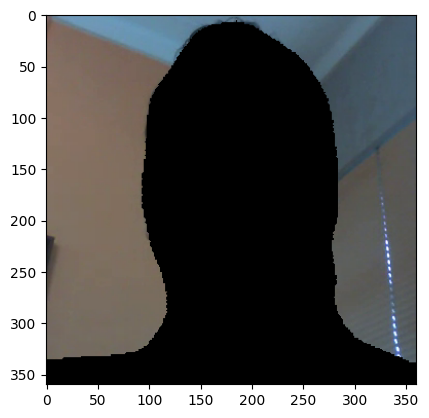

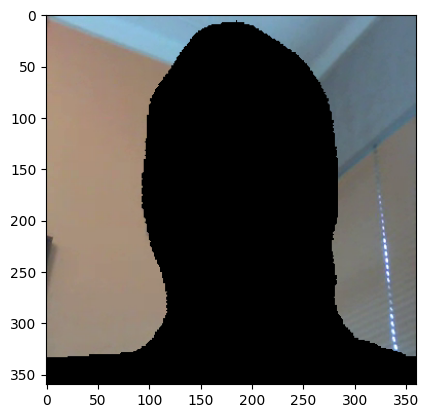

diff :  389.9851851851852


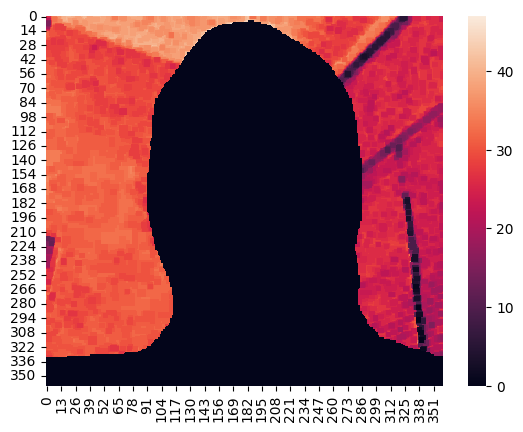

[105.16302108764648, 53.3930504322052, 262.1185326576233, 231.7679214477539]
[105.27367830276489, 65.12345552444458, 267.68304347991943, 260.0864267349243]
1.2001325590203258 0.833241288625904
motion : 94.43404689608188
re = False
[105.13235807418823, 65.19505977630615, 267.7618360519409, 259.94308948516846]
[93.58050227165222, 67.59865164756775, 267.63206005096436, 289.10874366760254]
1.3094909129556807 0.7636555474393313
motion : 98.00405629770427
re = False
[93.91018867492676, 67.59261131286621, 267.505202293396, 289.28735733032227]
[95.0465977191925, 66.10588431358337, 267.0043158531189, 284.49135303497314]
0.9642886129372615 1.0370339197037286
motion : 9.481362009985654
re = False
[95.05274534225464, 66.08945846557617, 267.0515012741089, 284.4728136062622]
[96.16374850273132, 66.4323627948761, 269.2479944229126, 283.9175748825073]
0.9908467300732262 1.009237826243921
motion : 5.454086356367309
re = False
[96.09715461730957, 66.40278339385986, 269.11341190338135, 283.88328552246094

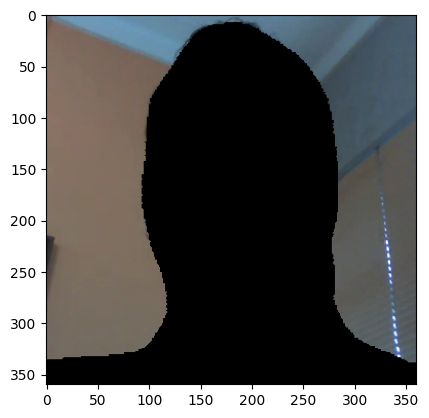

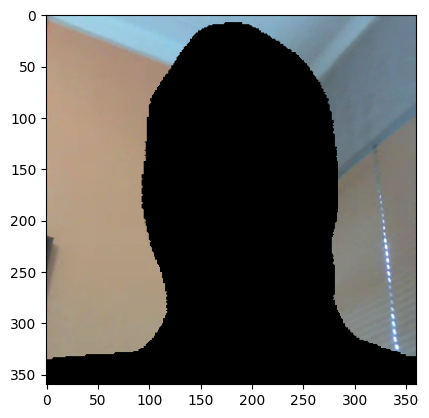

diff :  741.4926543209876


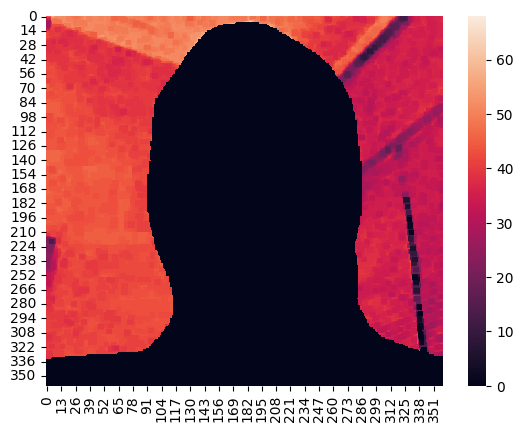

[107.08580017089844, 53.57914745807648, 263.21231603622437, 226.203453540802]
[102.66165733337402, 67.75820016860962, 268.9180397987366, 277.0085906982422]
1.4734872531658258 0.6786621315192743
motion : 183.71687428603005
re = True


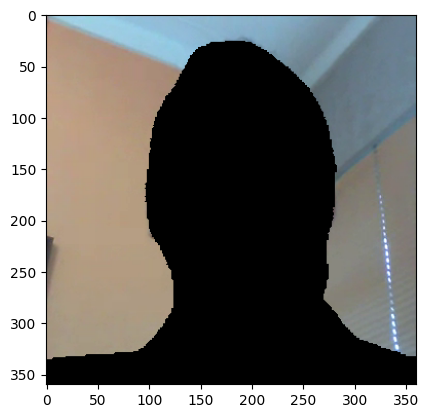

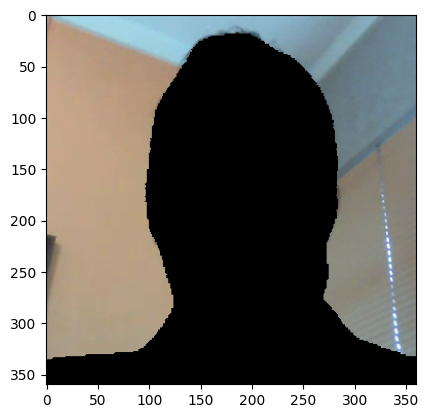

diff :  4.682091049382716
[102.79175519943237, 67.72961854934692, 269.2692160606384, 277.0091915130615]
[95.58420896530151, 66.44610643386841, 269.3117022514343, 286.0914731025696]
1.0975056689342404 0.9111570247933884
motion : 31.651580907239534
re = False
[95.55392146110535, 66.69564843177795, 269.34030532836914, 286.20075702667236]
[96.42398715019226, 66.4034914970398, 268.5493755340576, 284.78487253189087]
0.981900826446281 1.0184327918525378
motion : 5.987487807520099
re = False
[96.39524459838867, 66.38986587524414, 268.450562953949, 284.7860097885132]
[97.00523257255554, 66.42783522605896, 269.1778492927551, 283.42735290527344]
0.9908467300732262 1.009237826243921
motion : 2.7270431781836546
re = False
[96.99264764785767, 66.45452857017517, 269.2937636375427, 283.4507203102112]
[98.64563941955566, 66.37613296508789, 269.4068455696106, 281.19322299957275]
0.9816517658051774 1.018691184424013
motion : 6.154184839006408
re = False
[97.73656368255615, 67.10556507110596, 269.40021514

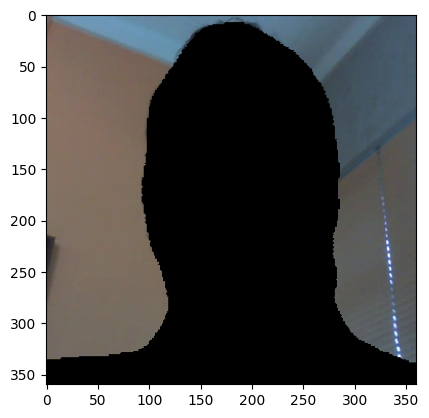

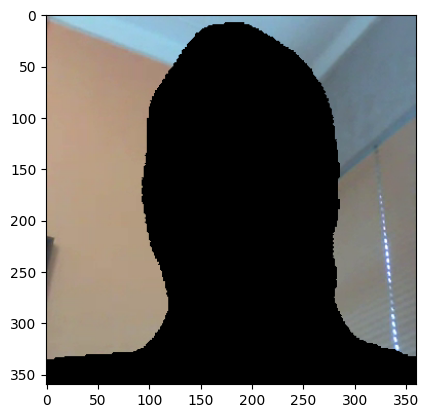

diff :  776.9856172839507


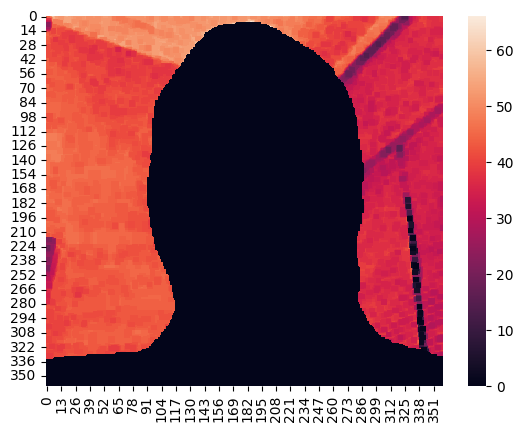

[107.50976085662842, 54.32747840881348, 262.7105927467346, 220.71172714233398]
[97.04060554504395, 69.77821469306946, 268.69213342666626, 286.1916160583496]
1.7088474379445493 0.5851897470746884
motion : 260.1654002754736
re = True


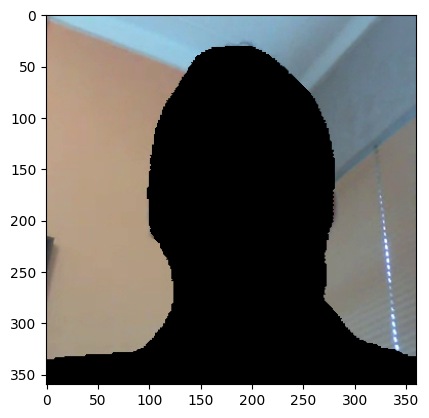

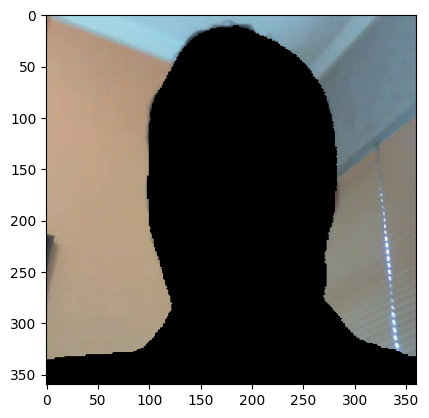

diff :  2.2958101851851853
[97.45892286300659, 69.87330436706543, 268.8079833984375, 286.5632629394531]
[94.443519115448, 66.53799891471863, 267.57878065109253, 285.5906295776367]
1.018518125252182 0.981818560914076
motion : 5.504470258446771
re = False
[94.48827981948853, 66.53623938560486, 267.45460510253906, 285.6419563293457]
[96.53358221054077, 66.7249059677124, 269.02150869369507, 284.40783977508545]
0.9908884301828569 1.009195353926437
motion : 11.141437607223553
re = False
[96.50901317596436, 66.74523711204529, 269.05635595321655, 284.4834566116333]
[96.84068441390991, 66.36661648750305, 269.37583923339844, 282.63599395751953]
0.9817355441461156 1.0186042524005487
motion : 2.7270431781836546
re = False
[96.81976318359375, 66.34785175323486, 269.40834760665894, 282.5673723220825]
[98.52397441864014, 67.784024477005, 268.7347912788391, 281.14234685897827]
0.9815672153635117 1.018778932657874
motion : 8.784104611578831
re = False
window sizw :  23
(8, 360, 360, 3)
(7, 360, 360, 3)

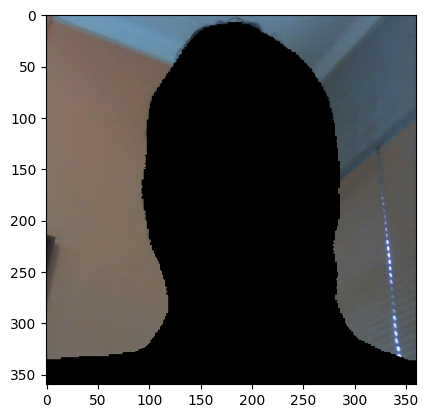

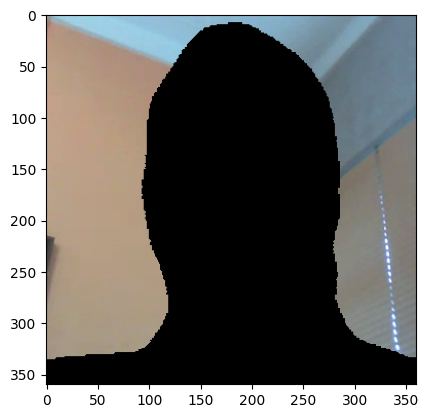

diff :  794.4095061728395


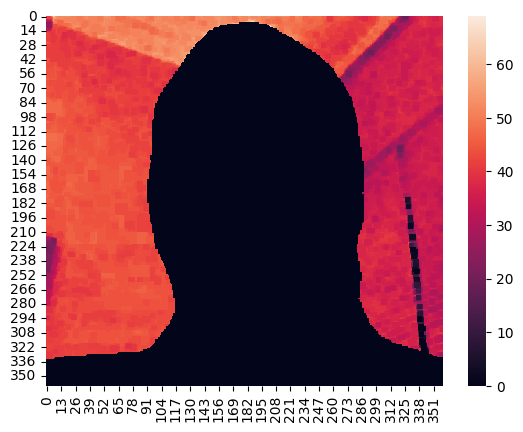

[108.90137672424316, 54.55538034439087, 261.89977169036865, 217.38544464111328]
[91.95074915885925, 69.77852582931519, 265.9380626678467, 291.83114290237427]
1.8549437314163122 0.5390999107215324
motion : 299.50251100424316
re = True


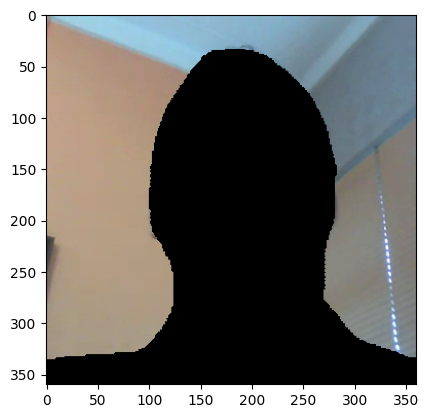

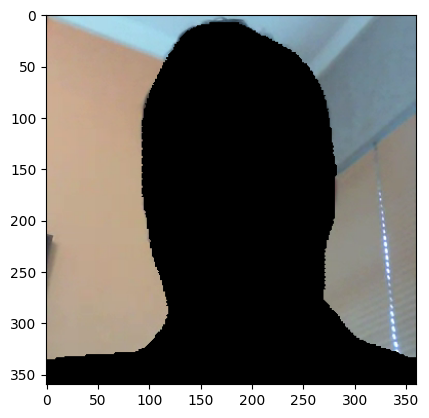

diff :  30.407631172839505


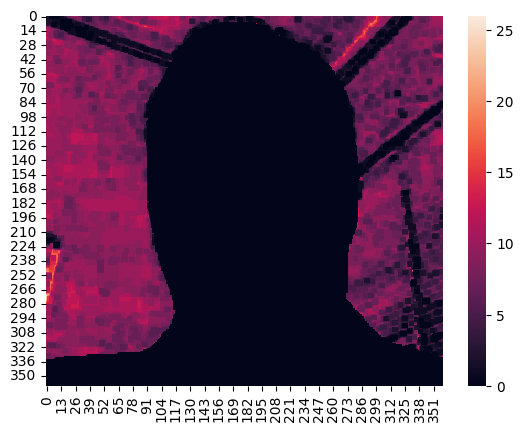

[92.2243881225586, 69.47833299636841, 265.8568239212036, 291.7131471633911]
[95.1781439781189, 67.1252954006195, 267.9533886909485, 284.5529365539551]
0.9554622189757325 1.046613858863004
motion : 20.538275261697553
re = False
[95.22433161735535, 67.11806416511536, 267.8255867958069, 284.5726776123047]
[97.05246090888977, 66.50439620018005, 269.9865245819092, 284.4092130661011]
1.009237826243921 0.9908467300732262
motion : 9.923324880548174
re = False
[96.99026584625244, 66.55466079711914, 269.73557710647583, 284.4579219818115]
[97.39573001861572, 66.13406896591187, 269.61642265319824, 281.4588260650635]
0.9726664422186685 1.0281016765819362
motion : 6.097853923995723
re = False
[97.06232070922852, 66.37904047966003, 269.5900297164917, 281.5215253829956]
[99.0283477306366, 69.3553376197815, 268.51802587509155, 279.50937509536743]
0.9540292049756626 1.0481859410430838
motion : 10.108803575989898
re = False
window sizw :  24
(8, 360, 360, 3)
(7, 360, 360, 3) (7, 360, 360, 3)
slide_idx : 

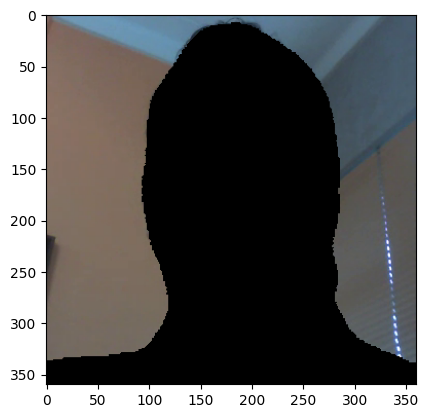

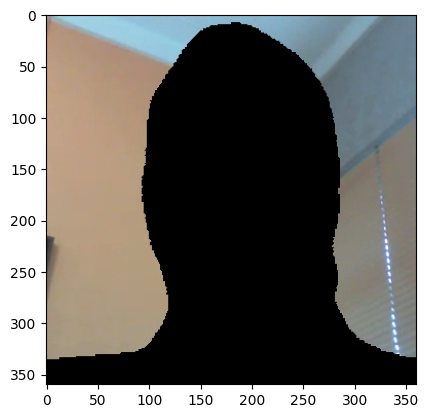

diff :  766.9135185185186


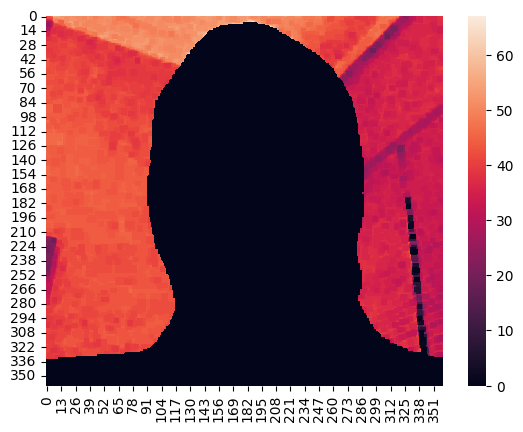

[109.57252979278564, 55.372472405433655, 260.8188199996948, 216.9082474708557]
[88.49610686302185, 68.07052731513977, 263.9163637161255, 290.560827255249]
1.9013155356660623 0.5259516273029786
motion : 313.1172860948131
re = True


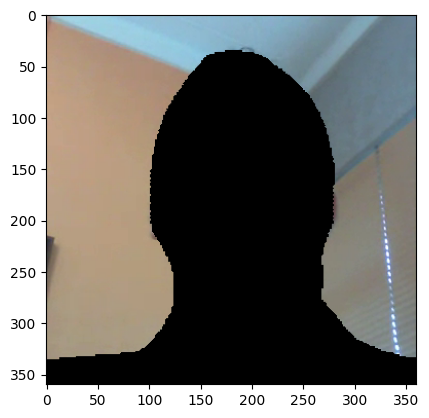

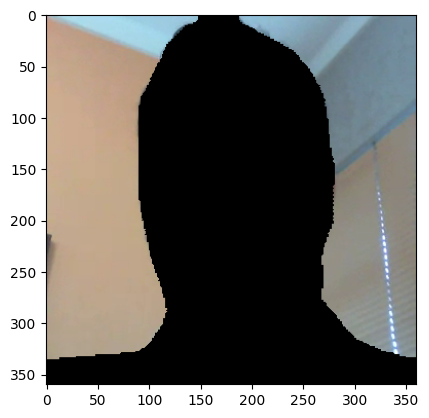

diff :  35.4201774691358


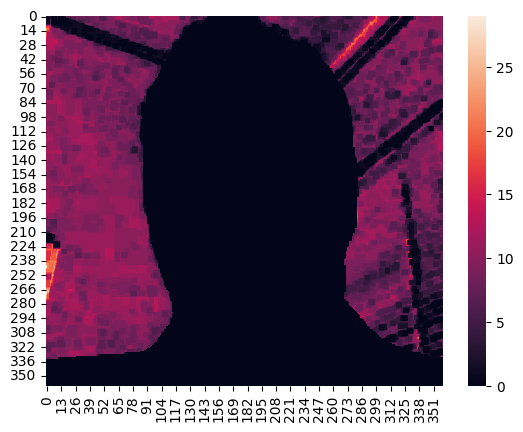

[88.24491262435913, 67.74799704551697, 264.2079734802246, 290.8472442626953]
[94.68064785003662, 67.28642106056213, 267.65525579452515, 284.38719749450684]
0.9469122644734461 1.0560640489286244
motion : 29.13736550945854
re = False
[94.62093114852905, 67.32421875, 267.69115447998047, 284.3651819229126]
[96.84373140335083, 66.48580312728882, 269.4366931915283, 284.41522121429443]
1.009237826243921 0.9908467300732262
motion : 8.256705387670156
re = False
[96.7980694770813, 66.50243282318115, 269.0837574005127, 284.3830347061157]
[97.89309740066528, 65.88120102882385, 269.4895648956299, 281.3514518737793]
0.9817355441461156 1.0186042524005487
motion : 8.181129534550964
re = False
[97.53226518630981, 66.16180300712585, 269.5420503616333, 281.4051389694214]
[99.09732341766357, 70.60275793075562, 268.4264659881592, 281.0140085220337]
0.9631368307193078 1.0382740729094135
motion : 7.929997952776772
re = False
window sizw :  25
(7, 360, 360, 3)
(6, 360, 360, 3) (6, 360, 360, 3)
slide_idx :  25

KeyboardInterrupt: 

In [14]:

for idx,path_video in enumerate(film_list) :
    if idx  ==0 :
        continue
    #j=0
    print(path_video , idx)
    file_name = os.path.basename(path_video).split(".")[-2]


    try :
            probe = ffmpeg.probe(path_video)
            video_info = next(s for s in probe['streams'] if s['codec_type'] == 'video')
            fps_video = int(video_info['r_frame_rate'].split('/')[0])
            width_video = int(probe['streams'][0]['width'])
            height_video = int(probe['streams'][0]['height'])
            #video_time = float(probe['streams'][0]['duration'])
            #number_of_frame = video_time*fps_video
            if fps_video > 30 :
                fps_video = 30
            fps= int(fps_video)
            print(fps)


    except :

        #os.remove(path_video)
        try :
            cap = cv2.VideoCapture(path_video)
            width_video  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH ))
            height_video = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT ))
            fps_video =  cap.get(cv2.CAP_PROP_FPS)
            if fps_video > 30 :
                fps_video = 30
                
            fps= fps_video
            print(fps)
        except :
             print("on cv2")
             continue
             #print("errrororororo")

    #print(fps)
    #try :
    stream = ffmpeg.input(path_video)
    stream = ffmpeg.filter(stream, 'fps', fps=fps, round='up')
    stream = ffmpeg.output(stream, 'pipe:', format='rawvideo', pix_fmt='rgb24')
    out, _ = ffmpeg.run(stream, capture_stdout=True)

    video = (
        np
        .frombuffer(out, np.uint8)
        .reshape([-1,height_video, width_video, 3])
    )
    # except :
        
    #         print("on ff")
    #         continue

    print(video.shape)
    video_size = video.shape[0]
    for slide_idx , i in enumerate(range(int(video_size/2))):
        print("window sizw : " , i)
        if i < 20 :

          continue

        buff_video = video[::i+1]
        #buff_video = sliding_window_view(buff_video,2,axis=0)
        print(buff_video.shape)

        buff_video_2 = buff_video[1:]
        buff_video_1 = buff_video[:-1]
        
        print(buff_video_2.shape ,buff_video_1.shape)
        

        with mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=2) as face_mesh_images :

                print("slide_idx : ",slide_idx)
                for idx_frame , (frame_2,frame_1) in enumerate(zip(buff_video_2 ,buff_video_1)) :
                  re,landif,a,b,c= motion_detection_fun(frame_1 , frame_2,face_mesh_images)
                  print("re =",re)

                  if re :
                        out1, MASK1 = segment(frame_1)

                        out2 , MASK2 = segment(frame_2)
                        

                        plt.imshow(out1)
                        plt.show()



                        out1_m = (out1>0)

                        out2_m = (out2>0)

                        out_m =  out1_m*out2_m

                        out1 = out1*out_m
                        out2 = out2*out_m

                        plt.imshow(out2)
                        plt.show()


                        out1 = cv2.cvtColor(out1,cv2.COLOR_BGR2GRAY)
                        out2 = cv2.cvtColor(out2,cv2.COLOR_BGR2GRAY)
                        out_1 = np.array(out1,dtype=np.float32)
                        out_2 = np.array(out2,dtype=np.float32)


                        diff = abs(out_2-out_1)

                        diff = cv2.erode(diff,np.ones((5, 5)))

                        heat_map = diff

                        err = np.sum((diff) ** 2)
                        err /= float(frame_2.shape[0] * frame_2.shape[1])

                        diff = err

                        # diff = mse(out1,out2)
                        print("diff : " , diff)

                        if diff > 5 :
                                
  
                                sb.heatmap(heat_map)
                                #os.mkdir("C:\\Users\\msi\\Desktop\\shenasa\\SHENASA_DATA\\VALIDATION\\VALIDATION_FILM\\SPOOF\\"+file_name+"_"+str(j))
                            
#                                 my_path = os.path.abspath("C:\\Users\\msi\\Desktop\\shenasa\\SHENASA_DATA\\VALIDATION\\REAL")
#                                 plt.savefig(os.path.join(my_path, file_name+"("+str(i)+")"+".png"))
                                plt.show()

#                                 np.save(os.path.join(my_path,file_name +"("+str(i)+")"+".npy") , np.array(heat_map,dtype=np.uint8))
                                #j+=1


   



    clear_output(wait=True)
                

In [ ]:
import ffmpeg

In [ ]:
sys.executable

In [ ]:
a = glob.glob("*.npy")+glob.glob("*.png")
for l  in a  :

  os.system("rm -r "+l) 

In [ ]:
# import os, random, shutil

# #Prompting user to enter number of files to select randomly along with directory
# source="C:\\Users\\msi\\Desktop\\hmarah_test_set\\hmarah_test_set\\spoof"
# dest="C:\\Users\\msi\\Desktop\\shenasa\\SHENASA_DATA\\VALIDATION\\VALIDATION_FILM\\SPOOF"
# # dest="C:\\Users\\msi\\Desktop\\shenasa\\SHENASA_DATA\\VALIDATION\\VALIDATION_FILM\\REAL"
# # spoof=real
# num=35
# # 80% for trainfilm (real and spoof)
# # num=282 
# # 10% for testfilm (real and spoof)
# # num=35
# # 10% for validatintfilm (real and spoof)
# # num=36



# print("%"*25+"{ Details Of Transfer }"+"%"*25)
# print("\n\nList of Files Moved to %s :-"%(dest))

# for i in range(num):
#     random_file=random.choice(os.listdir(source))
#     print("%d} %s"%(i+1,random_file))
#     source_file="%s/%s"%(source,random_file)
#     dest_file=dest
#     shutil.move(source_file,dest_file)

# print("\n\n"+"$"*33+"[ Files Moved Successfully ]"+"$"*33)